<a href="https://colab.research.google.com/github/amanteur/MLDM_KaggleProject/blob/main/MLDM_project_model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
import random

%matplotlib inline

In [ ]:
SAVE_PATH = '/content/drive/MyDrive/datasets/kaggle_musrec/prepr_v3/'

In [ ]:
train = pd.read_csv(SAVE_PATH + 'train.csv', dtype={'language': str,
                                                    'song_length_cat': str,
                                                    'decade': str},
                    index_col = 0)
val = pd.read_csv(SAVE_PATH + 'val.csv', dtype={'language': str,
                                                'song_length_cat': str,
                                                'decade': str},
                    index_col = 0)
test = pd.read_csv(SAVE_PATH + 'test.csv', dtype={'genre_first':str,
                                                  'language': str,
                                                  'song_length_cat': str,
                                                  'decade': str},
                    index_col = 0)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [ ]:
for col in train.columns:
  if train[col].dtype == object:
    train[col] = train[col].astype('category')
for col in val.columns:
  if val[col].dtype == object:
    val[col] = val[col].astype('category')
for col in test.columns:
  if test[col].dtype == object:
    test[col] = test[col].astype('category')

In [ ]:
# cols = ['source_system_tab', 'source_screen_name', 'source_type', 'user_plays',
      #  'song_plays', 'city', 'bd',
      #  'gender', 'registered_via', 'membership_days', 'artist_name',
      #  'composer', 'lyricist', 'language', 'genre_ids', 'song_length_cat',
      #  'artist_name_number', 'composer_number', 'lyricist_number',
      #  'genre_number', 'name', 'decade', 'country', 'genre_first']
cols = ['source_type', 'song_plays', 'source_screen_name', 
        'source_system_tab', 'user_plays', 'name', 'membership_days']

In [ ]:
import gc

X_train = train[cols]
y_train = train['target'].values

X_val = val[cols]
y_val = val['target'].values

X_test = test[cols]

In [ ]:
del train, val, test; gc.collect()

33213

# LGBM

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 13.8 MB/s 
     |████████████████████████████████| 80 kB 7.3 MB/s 
     |████████████████████████████████| 209 kB 58.5 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 81.7 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 149 kB 79.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=60c85527889967a2b1d3868c58653e856744bdc04f8721f9adb4d13c5e310d50
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import lightgbm as lgbm
import optuna 
from sklearn.metrics import roc_auc_score

In [ ]:
d_train = lgbm.Dataset(X_train, y_train)
d_val = lgbm.Dataset(X_val, y_val)

### simple

In [ ]:
params = {}
params['learning_rate'] = 0.2
params['objective'] = 'binary'
params['min_child_samples'] = 100
params['bagging_fraction'] = 0.7
params['feature_fraction'] = 0.7
params['bagging_frequency'] = 5
params['metric'] = 'auc'

In [ ]:
print('Training LGBM model...')
model = lgbm.train(params, 
                  train_set=d_train, 
                  num_boost_round=15000, 
                  early_stopping_rounds=100, 
                  valid_sets=d_val,
                  verbose_eval=20)

Training LGBM model...


categorical_feature in param dict is overridden.


Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.643694
[40]	valid_0's auc: 0.646641
[60]	valid_0's auc: 0.647726
[80]	valid_0's auc: 0.648794
[100]	valid_0's auc: 0.649455
[120]	valid_0's auc: 0.65014
[140]	valid_0's auc: 0.650373
[160]	valid_0's auc: 0.650634
[180]	valid_0's auc: 0.650967
[200]	valid_0's auc: 0.65167
[220]	valid_0's auc: 0.651893
[240]	valid_0's auc: 0.651881
[260]	valid_0's auc: 0.65206
[280]	valid_0's auc: 0.652168
[300]	valid_0's auc: 0.652326
[320]	valid_0's auc: 0.652677
[340]	valid_0's auc: 0.65317
[360]	valid_0's auc: 0.653352
[380]	valid_0's auc: 0.653796
[400]	valid_0's auc: 0.654059
[420]	valid_0's auc: 0.654212
[440]	valid_0's auc: 0.654439
[460]	valid_0's auc: 0.654574
[480]	valid_0's auc: 0.654573
[500]	valid_0's auc: 0.654637
[520]	valid_0's auc: 0.654996
[540]	valid_0's auc: 0.655106
[560]	valid_0's auc: 0.655226
[580]	valid_0's auc: 0.655443
[600]	valid_0's auc: 0.655537
[620]	valid_0's auc: 0.655588
[640]	valid_0's

In [ ]:
predictions = model.predict(X_test)
subm = pd.DataFrame()
subm['id'] = test.index.values
subm['target'] = predictions
subm.to_csv(SAVE_PATH + 'lgbm_submission_final.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

In [ ]:
print(13)

### optuna

#### tuning

In [ ]:
def objective(trial, d_train, d_val, X_val, y_val):
    param_grid = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
        "metric": "auc"
    }

    model = lgbm.train(param_grid, 
                      train_set=d_train, 
                      early_stopping_rounds=50, 
                      valid_sets=[d_train, d_val],
                      verbose_eval=20)
    y_pred = model.predict(X_val)

    return roc_auc_score(y_val, y_pred)

In [ ]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, 
                               d_train_no_rat, 
                               d_val_no_rat, 
                               X_val, 
                               y_val)
study.optimize(func, n_trials=10)

[I 2021-12-20 16:10:03,094] A new study created in memory with name: LGBM Classifier
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.718377	valid_1's auc: 0.642516
[40]	training's auc: 0.721911	valid_1's auc: 0.643312
[60]	training's auc: 0.722701	valid_1's auc: 0.643928
[80]	training's auc: 0.723237	valid_1's auc: 0.64406
[100]	training's auc: 0.723467	valid_1's auc: 0.644341
[120]	training's auc: 0.723676	valid_1's auc: 0.644494
[140]	training's auc: 0.723798	valid_1's auc: 0.644709
[160]	training's auc: 0.723924	valid_1's auc: 0.644881
[180]	training's auc: 0.724023	valid_1's auc: 0.644775
[200]	training's auc: 0.724076	valid_1's auc: 0.64469
Early stopping, best iteration is:
[152]	training's auc: 0.723913	valid_1's auc: 0.644962


[I 2021-12-20 16:19:11,528] Trial 0 finished with value: 0.6448539805226994 and parameters: {'n_estimators': 300, 'learning_rate': 0.28472018755953205, 'num_leaves': 1300, 'max_depth': 10, 'min_data_in_leaf': 200, 'lambda_l1': 45, 'lambda_l2': 70, 'min_gain_to_split': 6.282809938235776, 'bagging_fraction': 0.2, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.6448539805226994.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.708313	valid_1's auc: 0.637952
[40]	training's auc: 0.712366	valid_1's auc: 0.640057
[60]	training's auc: 0.715448	valid_1's auc: 0.642351
[80]	training's auc: 0.717375	valid_1's auc: 0.643686
[100]	training's auc: 0.718374	valid_1's auc: 0.644843
[120]	training's auc: 0.718794	valid_1's auc: 0.645231
[140]	training's auc: 0.719089	valid_1's auc: 0.64555
[160]	training's auc: 0.719204	valid_1's auc: 0.645735
[180]	training's auc: 0.719226	valid_1's auc: 0.645781
[200]	training's auc: 0.719226	valid_1's auc: 0.645781
[220]	training's auc: 0.719226	valid_1's auc: 0.645781
Early stopping, best iteration is:
[178]	training's auc: 0.719226	valid_1's auc: 0.645781


[I 2021-12-20 16:27:05,599] Trial 1 finished with value: 0.6457760736592572 and parameters: {'n_estimators': 300, 'learning_rate': 0.08570153721133195, 'num_leaves': 1200, 'max_depth': 9, 'min_data_in_leaf': 8600, 'lambda_l1': 80, 'lambda_l2': 35, 'min_gain_to_split': 14.220831152287357, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 0 with value: 0.6448539805226994.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.714228	valid_1's auc: 0.642846
[40]	training's auc: 0.719698	valid_1's auc: 0.645335
[60]	training's auc: 0.721903	valid_1's auc: 0.646702
[80]	training's auc: 0.72248	valid_1's auc: 0.646809
[100]	training's auc: 0.722729	valid_1's auc: 0.64693
[120]	training's auc: 0.722823	valid_1's auc: 0.646983
[140]	training's auc: 0.722823	valid_1's auc: 0.646983
Early stopping, best iteration is:
[106]	training's auc: 0.722812	valid_1's auc: 0.646985


[I 2021-12-20 16:33:50,997] Trial 2 finished with value: 0.6469788401697149 and parameters: {'n_estimators': 300, 'learning_rate': 0.20894429110768556, 'num_leaves': 20, 'max_depth': 12, 'min_data_in_leaf': 800, 'lambda_l1': 75, 'lambda_l2': 75, 'min_gain_to_split': 10.653756654908081, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.5}. Best is trial 0 with value: 0.6448539805226994.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.694746	valid_1's auc: 0.625747
[40]	training's auc: 0.702973	valid_1's auc: 0.632301
[60]	training's auc: 0.707653	valid_1's auc: 0.636916
[80]	training's auc: 0.710777	valid_1's auc: 0.639776
[100]	training's auc: 0.712437	valid_1's auc: 0.641273
[120]	training's auc: 0.713277	valid_1's auc: 0.642096
[140]	training's auc: 0.713745	valid_1's auc: 0.64257
[160]	training's auc: 0.714175	valid_1's auc: 0.643077
[180]	training's auc: 0.714303	valid_1's auc: 0.643276
[200]	training's auc: 0.714402	valid_1's auc: 0.643399
[220]	training's auc: 0.714463	valid_1's auc: 0.643452
[240]	training's auc: 0.714463	valid_1's auc: 0.643452
[260]	training's auc: 0.714463	valid_1's auc: 0.643452
Early stopping, best iteration is:
[217]	training's auc: 0.714463	valid_1's auc: 0.643452


[I 2021-12-20 16:43:30,587] Trial 3 finished with value: 0.6434413834124942 and parameters: {'n_estimators': 300, 'learning_rate': 0.17557976502534878, 'num_leaves': 1200, 'max_depth': 5, 'min_data_in_leaf': 2800, 'lambda_l1': 25, 'lambda_l2': 20, 'min_gain_to_split': 11.494737463103041, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.2}. Best is trial 3 with value: 0.6434413834124942.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.714955	valid_1's auc: 0.642937
[40]	training's auc: 0.720515	valid_1's auc: 0.645679
[60]	training's auc: 0.722418	valid_1's auc: 0.646938
[80]	training's auc: 0.723399	valid_1's auc: 0.647492
[100]	training's auc: 0.723405	valid_1's auc: 0.647718
[120]	training's auc: 0.72345	valid_1's auc: 0.647794
[140]	training's auc: 0.72345	valid_1's auc: 0.647794
[160]	training's auc: 0.72345	valid_1's auc: 0.647794
Early stopping, best iteration is:
[117]	training's auc: 0.723453	valid_1's auc: 0.647772


[I 2021-12-20 16:50:02,638] Trial 4 finished with value: 0.6477778253127886 and parameters: {'n_estimators': 300, 'learning_rate': 0.18465224689632115, 'num_leaves': 520, 'max_depth': 9, 'min_data_in_leaf': 2300, 'lambda_l1': 45, 'lambda_l2': 100, 'min_gain_to_split': 8.218009307179788, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.4}. Best is trial 3 with value: 0.6434413834124942.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.705242	valid_1's auc: 0.635413
[40]	training's auc: 0.713135	valid_1's auc: 0.642783
[60]	training's auc: 0.71632	valid_1's auc: 0.645734
[80]	training's auc: 0.717771	valid_1's auc: 0.646569
[100]	training's auc: 0.718903	valid_1's auc: 0.647134
[120]	training's auc: 0.719498	valid_1's auc: 0.647371
[140]	training's auc: 0.720425	valid_1's auc: 0.647636
[160]	training's auc: 0.721355	valid_1's auc: 0.648107
[180]	training's auc: 0.721894	valid_1's auc: 0.648359
[200]	training's auc: 0.722622	valid_1's auc: 0.648512
[220]	training's auc: 0.722837	valid_1's auc: 0.64868
[240]	training's auc: 0.723005	valid_1's auc: 0.648728
[260]	training's auc: 0.723198	valid_1's auc: 0.648862
[280]	training's auc: 0.723461	valid_1's auc: 0.649044
[300]	training's auc: 0.72355	valid_1's auc: 0.649092
Did not meet early stopping. Best iteration is:
[300]	training's auc: 0.72355	valid_1's auc: 0.649092


[I 2021-12-20 16:59:51,679] Trial 5 finished with value: 0.6490853238990332 and parameters: {'n_estimators': 300, 'learning_rate': 0.26800590122637774, 'num_leaves': 20, 'max_depth': 4, 'min_data_in_leaf': 5500, 'lambda_l1': 5, 'lambda_l2': 35, 'min_gain_to_split': 1.1398376268687587, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 0.30000000000000004}. Best is trial 3 with value: 0.6434413834124942.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.721152	valid_1's auc: 0.645911
[40]	training's auc: 0.724626	valid_1's auc: 0.647496
[60]	training's auc: 0.724782	valid_1's auc: 0.647564
[80]	training's auc: 0.724782	valid_1's auc: 0.647564
[100]	training's auc: 0.724782	valid_1's auc: 0.647564
Early stopping, best iteration is:
[50]	training's auc: 0.724775	valid_1's auc: 0.647591


[I 2021-12-20 17:03:43,118] Trial 6 finished with value: 0.6475753415637031 and parameters: {'n_estimators': 300, 'learning_rate': 0.19553690721846115, 'num_leaves': 1520, 'max_depth': 10, 'min_data_in_leaf': 4400, 'lambda_l1': 65, 'lambda_l2': 50, 'min_gain_to_split': 3.658143979531634, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 3 with value: 0.6434413834124942.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.717832	valid_1's auc: 0.644433
[40]	training's auc: 0.719789	valid_1's auc: 0.645545
[60]	training's auc: 0.721422	valid_1's auc: 0.646155
[80]	training's auc: 0.722334	valid_1's auc: 0.646452
[100]	training's auc: 0.7228	valid_1's auc: 0.646543
[120]	training's auc: 0.723018	valid_1's auc: 0.646534
[140]	training's auc: 0.723018	valid_1's auc: 0.646534
[160]	training's auc: 0.723018	valid_1's auc: 0.646534
Early stopping, best iteration is:
[113]	training's auc: 0.722979	valid_1's auc: 0.646584


[I 2021-12-20 17:09:04,650] Trial 7 finished with value: 0.6465798080251585 and parameters: {'n_estimators': 300, 'learning_rate': 0.2945631395518533, 'num_leaves': 80, 'max_depth': 5, 'min_data_in_leaf': 300, 'lambda_l1': 35, 'lambda_l2': 70, 'min_gain_to_split': 13.549716275645507, 'bagging_fraction': 0.8, 'bagging_freq': 1, 'feature_fraction': 0.9}. Best is trial 3 with value: 0.6434413834124942.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.714698	valid_1's auc: 0.641746
[40]	training's auc: 0.717549	valid_1's auc: 0.643562
[60]	training's auc: 0.719097	valid_1's auc: 0.644706
[80]	training's auc: 0.719607	valid_1's auc: 0.645143
[100]	training's auc: 0.719721	valid_1's auc: 0.645279
[120]	training's auc: 0.719808	valid_1's auc: 0.645365
[140]	training's auc: 0.719808	valid_1's auc: 0.645365
[160]	training's auc: 0.719808	valid_1's auc: 0.645365
Early stopping, best iteration is:
[111]	training's auc: 0.719805	valid_1's auc: 0.645367


[I 2021-12-20 17:15:22,421] Trial 8 finished with value: 0.6453623326111678 and parameters: {'n_estimators': 300, 'learning_rate': 0.07187356073901582, 'num_leaves': 2900, 'max_depth': 11, 'min_data_in_leaf': 7100, 'lambda_l1': 30, 'lambda_l2': 85, 'min_gain_to_split': 6.703129172561743, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 3 with value: 0.6434413834124942.
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `n_estimators` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[20]	training's auc: 0.720458	valid_1's auc: 0.645574
[40]	training's auc: 0.725051	valid_1's auc: 0.647587
[60]	training's auc: 0.726669	valid_1's auc: 0.648713
[80]	training's auc: 0.727512	valid_1's auc: 0.64897
[100]	training's auc: 0.727862	valid_1's auc: 0.649056
[120]	training's auc: 0.727945	valid_1's auc: 0.649059
[140]	training's auc: 0.727945	valid_1's auc: 0.649059
Early stopping, best iteration is:
[103]	training's auc: 0.727905	valid_1's auc: 0.649064


[I 2021-12-20 17:21:12,989] Trial 9 finished with value: 0.6490585226052848 and parameters: {'n_estimators': 300, 'learning_rate': 0.12355150891172534, 'num_leaves': 1500, 'max_depth': 8, 'min_data_in_leaf': 1100, 'lambda_l1': 40, 'lambda_l2': 75, 'min_gain_to_split': 12.711095026165466, 'bagging_fraction': 0.9, 'bagging_freq': 1, 'feature_fraction': 0.7}. Best is trial 3 with value: 0.6434413834124942.


In [ ]:
print(f"\tBest value (auc): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.64344
	Best params:
		n_estimators: 300
		learning_rate: 0.17557976502534878
		num_leaves: 1200
		max_depth: 5
		min_data_in_leaf: 2800
		lambda_l1: 25
		lambda_l2: 20
		min_gain_to_split: 11.494737463103041
		bagging_fraction: 0.6000000000000001
		bagging_freq: 1
		feature_fraction: 0.2


#### predicting

In [ ]:
best_params = {
              'objective': 'binary',
              'boosting': 'dart',
              'learning_rate': 0.17557976502534878,
              'num_leaves': 1200,
              'max_depth': 5,
              'min_data_in_leaf': 2800,
              'lambda_l1': 25,
              'lambda_l2': 20,
              'min_gain_to_split': 11.494737463103041,
              'bagging_fraction': 0.6,
              'bagging_freq': 1,
              'feature_fraction': 0.2,
              "num_rounds": 200,
              "metric": "auc"
              }

In [ ]:
model = lgbm.train(best_params, 
                  train_set=d_train, 
                  early_stopping_rounds=60, 
                  valid_sets=d_val,
                  verbose_eval=20)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_rounds` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

/usr/local/lib/python3.7/dist-packages/lightgbm/callback.py:189: UserWarning:

Early stopping is not available in dart mode



[20]	valid_0's auc: 0.627059
[40]	valid_0's auc: 0.63335
[60]	valid_0's auc: 0.635875
[80]	valid_0's auc: 0.637921
[100]	valid_0's auc: 0.638547
[120]	valid_0's auc: 0.6392
[140]	valid_0's auc: 0.640519
[160]	valid_0's auc: 0.641875
[180]	valid_0's auc: 0.642231
[200]	valid_0's auc: 0.642662


In [ ]:
predictions = model.predict(X_test)
subm = pd.DataFrame()
subm['id'] = X_test.index.values
subm['target'] = predictions
subm.to_csv(SAVE_PATH + 'lgbm_submission_opt.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

Done!


## SHAP

In [ ]:
!pip install shap

     |████████████████████████████████| 564 kB 13.8 MB/s 


In [ ]:
import shap

In [ ]:
# DF, based on which importance is checked
X_importance = X_val

# Explain model predictions using shap library:
explainer = shap.TreeExplainer(model)

In [ ]:
shap_values = explainer.shap_values(X_importance)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


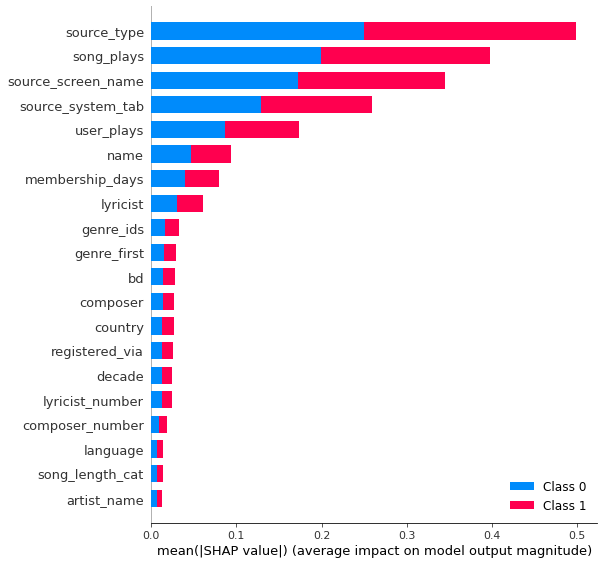

In [ ]:
shap.summary_plot(shap_values, X_importance)

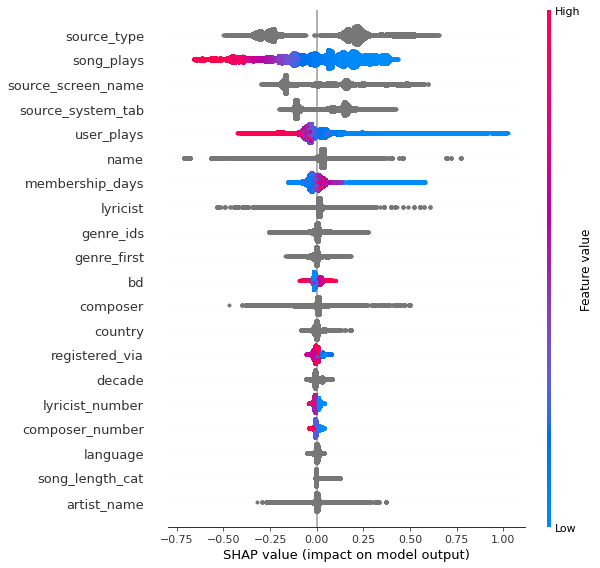

In [ ]:
shap.summary_plot(shap_values[0], X_importance)

In [ ]:
shap_sum = np.abs(shap_values[1]).mean(axis=0)
importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df

,column_name,shap_importance
2,source_type,0.249378
4,song_plays,0.198826
1,source_screen_name,0.172238
0,source_system_tab,0.129468
3,user_plays,0.0869249
20,name,0.046885
9,membership_days,0.0396551
12,lyricist,0.0303834
14,genre_ids,0.0166515
23,genre_first,0.0146653


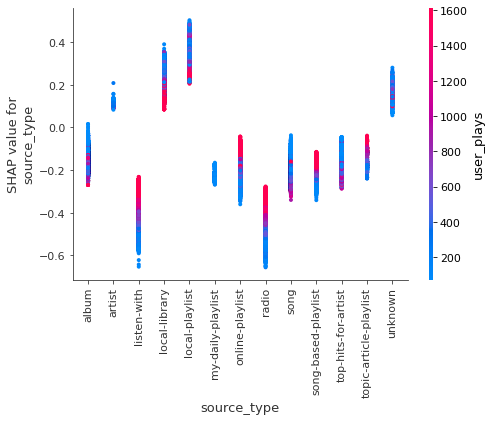

In [ ]:
shap.dependence_plot(
    "source_type",
    shap_values[1], X_importance)

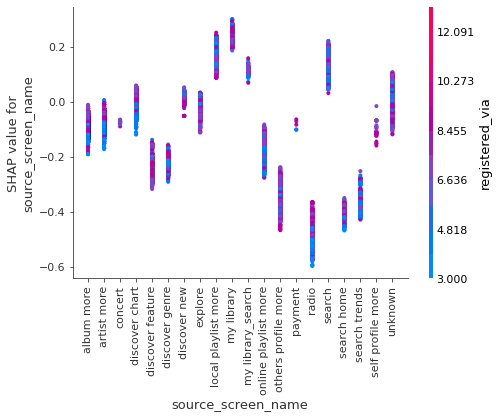

In [ ]:
shap.dependence_plot(
    "source_screen_name",
    shap_values[1], X_importance)

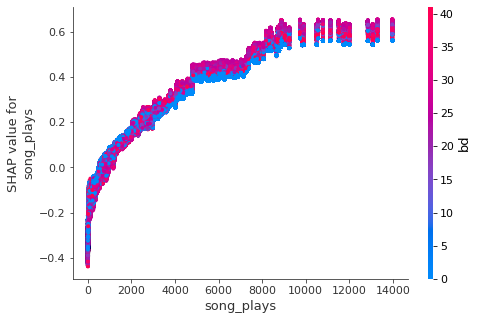

In [ ]:
shap.dependence_plot(
    "song_plays",
    shap_values[1], X_importance)

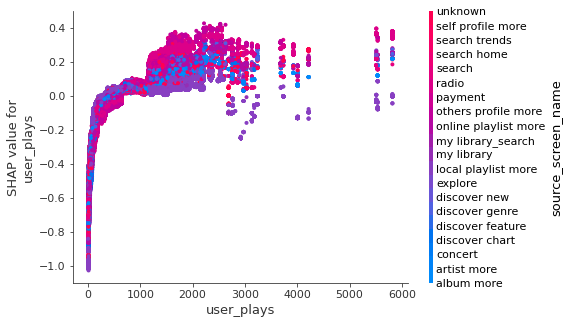

In [ ]:
shap.dependence_plot(
    "user_plays",
    shap_values[1], X_importance)

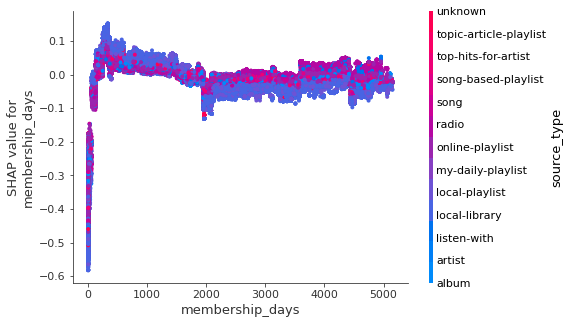

In [ ]:
shap.dependence_plot(
    "membership_days",
    shap_values[1], X_importance)

# From kaggle

In [ ]:
kaggle_params_1 = {
        'objective': 'binary',
        'boosting': 'dart',
        'learning_rate': 0.3 ,
        'verbose': 0,
        'num_leaves': 108,
        'bagging_fraction': 0.95,
        'bagging_freq': 1,
        'bagging_seed': 1,
        'feature_fraction': 0.9,
        'feature_fraction_seed': 1,
        'max_bin': 256,
        'max_depth': 10,
        'num_rounds': 150,
        'metric' : 'auc'
    }

In [ ]:
kaggle_model_1 = lgbm.train(kaggle_params_1, 
                  train_set=d_train_no_rat, 
                  early_stopping_rounds=30, 
                  valid_sets=d_val_no_rat,
                  verbose_eval=10)

Found `num_rounds` in params. Will use it instead of argument
Early stopping is not available in dart mode


[10]	valid_0's auc: 0.645869
[20]	valid_0's auc: 0.648711
[30]	valid_0's auc: 0.649566
[40]	valid_0's auc: 0.649907
[50]	valid_0's auc: 0.650097
[60]	valid_0's auc: 0.650319
[70]	valid_0's auc: 0.650668
[80]	valid_0's auc: 0.650642
[90]	valid_0's auc: 0.65087
[100]	valid_0's auc: 0.650998
[110]	valid_0's auc: 0.65111
[120]	valid_0's auc: 0.651513
[130]	valid_0's auc: 0.651239
[140]	valid_0's auc: 0.651775
[150]	valid_0's auc: 0.652116


In [ ]:
predictions = kaggle_model_1.predict(X_test)
subm = pd.DataFrame()
subm['id'] = X_test.index.values
subm['target'] = predictions
subm.to_csv(SAVE_PATH + 'lgbm_submission.csv.gz', compression = 'gzip', index=False, float_format = '%.5f')

print('Done!')

Done!


In [ ]:
predictions

array([0.28058701, 0.50720177, 0.04398988, ..., 0.24246205, 0.29535119,
       0.3069336 ])